In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regions import Regions
import regions
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs

from smart_plotters.jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
from smart_plotters.cutout_plot import get_cutout_405, get_cutout_jwst_ice
from smart_plotters import cmd_plot

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [53]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
reg_c1 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc1.region')
reg_c2 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc2.region')
reg_d = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudd.region')
reg_b = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudb.region')
reg_left = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/leftmost.reg')

- Group stars in 5x5” bins (or whatever size bin, be flexible)
- Select the stars that are clearly behind (so there’s some varying threshold of A_V…. probably A_V>25 is the stuff you can be sure is behind a cloud).
- Deredden these stars
- Determine the faintest magnitude you detect in F212N, say
- Count the number of stars in the foreground (A_V < 25, but still A_V > 17 so they’re in the CMZ) that have mag < threshold
- deredden to 17th mag (you could do that by dereddening, then reddening back to 17th), reject that star from the background population if it is brighter than our saturation limit - which is M=15, roughly
- “Depth” = n_foreground / (n_back + n_fore), where both n_fore and n_back are the magnitude-limited sample
- Make images of this effective depth in various bin sizes (5”, 2.5”, 10”, whatever)
- THEN, let’s do the same thing but define fore/back as “no ice” vs “has ice”
- This lets us distinguish “behind cloud” vs “behind whole CMZ”
- Probably best to do this as a combined F182M-F212N + F405N-F466N diagonal cut, based on 


# Measuring Relative Depth

## Group Stars in 5"x5" bins (or a flexible bin size)

In [57]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
nanfield = np.full(hdu['SCI'].data.shape, np.nan)

In [5]:
cat_use = make_cat_use()


In [6]:
#cat_use = JWSTCatalog(cat_use.table_region_mask(reg_f, ww))

In [7]:
pos_hmsfr = SkyCoord('17:46:21.4669695284', '-28:35:38.1118497742', unit=(u.hourangle, u.deg))
ra = pos_hmsfr.ra - 25 *u.arcsec
dec = pos_hmsfr.dec + 20 *u.arcsec
pos_cloudc = SkyCoord(ra, dec)
l = 120*u.arcsec
w = 140*u.arcsec

cutout_cloudc = get_cutout_405(pos_cloudc, w, l)

In [8]:
def star_density_color(tbl, ww, dx=1*u.arcsec, size=(2.6*u.arcmin, 8.4*u.arcmin)):
    bins_ra = np.arange(0, size[1].to(u.arcsec).value, dx.to(u.arcsec).value)
    bins_dec = np.arange(0, size[0].to(u.arcsec).value, dx.to(u.arcsec).value)

    bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
    bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

    crds_pix = np.array(ww.world_to_pixel(tbl['skycoord_ref']))

    h, xedges, yedges = np.histogram2d(crds_pix[1], crds_pix[0], bins=[bins_pix_dec, bins_pix_ra])
    # h[h==0] = np.nan
    return h

In [9]:
h = star_density_color(cat_use.catalog, ww, dx=2*u.arcsec)
h_5 = star_density_color(cat_use.catalog, ww, dx=5*u.arcsec)

In [10]:
def star_density_color_wcs(ww, dx=1*u.arcsec, size=(2.6*u.arcmin, 8.4*u.arcmin)):
    # Adjust the WCS so that it has the correct pixel size and shape
    # dx = pixel size
    # size = shape of the image in world coordinates
    wcs_new = ww.deepcopy()
    #wcs_new.wcs.crpix = [1, 1]
    #wcs_new.wcs.crval = [ww.wcs.crval[0], ww.wcs.crval[1]]
    #wcs_new.wcs.cdelt = [dx.to(u.deg).value, dx.to(u.deg).value]
    ##[ww.proj_plane_pixel_scales()[1].to(u.deg).value, ww.proj_plane_pixel_scales()[0].to(u.deg).value]
    ##wcs_new.wcs.ctype = ww.wcs.ctype
    shape_pix = (size[0]/dx).to(u.dimensionless_unscaled).value, (size[1]/dx).to(u.dimensionless_unscaled).value

    wcs_dict = {
        'SIMPLE' : 'T',
        'BITPIX' : -64,
        'NAXIS'  : 2,
        'NAXIS1' : shape_pix[0],
        'NAXIS2' : shape_pix[1],
        'WCSAXES' : 2,
        'CRPIX1' : shape_pix[0]/2,
        'CRPIX2' : shape_pix[1]/2,
        'CDELT1' : -(dx).to(u.deg).value,
        'CDELT2' : dx.to(u.deg).value,
        'CROTA2' : -4, 
        'CUNIT1' : 'deg',
        'CUNIT2' : 'deg',
        'CTYPE1' : 'RA---TAN',
        'CTYPE2' : 'DEC--TAN',
        'CRVAL1' : ww.wcs.crval[0],
        'CRVAL2' : ww.wcs.crval[1],
        'BUNIT' : 'Stars/px'
    }
    wcs_new = WCS(wcs_dict)
    #wcs_new.update(WCS(wcs_dict))
    return wcs_new, shape_pix
    
new_wcs, shape_pix = star_density_color_wcs(ww, dx=5*u.arcsec)

## Select the stars that are clearly behind the clouds

so there’s some varying threshold of A_V…. probably A_V>25 is the stuff you can be sure is behind a cloud

In [11]:
cat_use.catalog['Av'] = cat_use.get_Av('f182m', 'f212n') #cat_use.get_Av('f212n', 'f405n')

In [12]:
red_lim = 25 # 20 # 22 # 25

cat_red = JWSTCatalog(cat_use.catalog[cat_use.catalog['Av'] > red_lim])
#JWSTCatalog(cat_use.catalog[cat_use.catalog['Av'] > 25])

In [13]:
blue_lim = 17

cat_blue = JWSTCatalog(cat_use.catalog[cat_use.catalog['Av'] < blue_lim])

In [14]:
h_red = star_density_color(cat_red.catalog, ww, dx=5*u.arcsec)
h_blue = star_density_color(cat_blue.catalog, ww, dx=5*u.arcsec)

In [15]:
#ax = plt.subplot(projection=ww)
#ax.imshow(hdu['SCI'].data, origin='lower', cmap='gray', vmin=0, vmax=50)
#reg_d[0].to_pixel(ww).plot(ax=ax, edgecolor='cyan', facecolor='none')


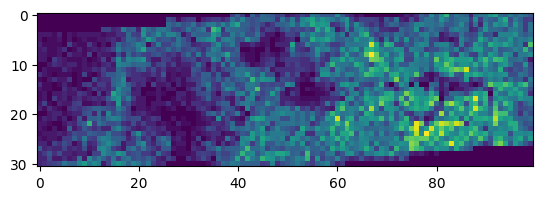

In [16]:
#ax = plt.subplot(projection=new_wcs)
plt.imshow(np.flip(h_red, axis=0))
#ax.imshow(np.flip(h_red.T, axis=0))
#reg_d[0].to_pixel(new_wcs).plot(ax=ax, edgecolor='cyan', facecolor='none')

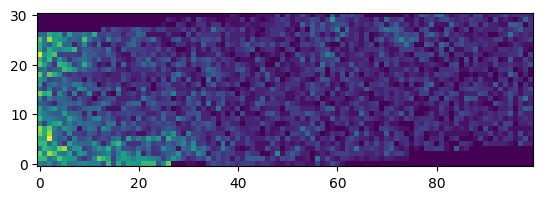

In [17]:
plt.imshow(h_blue, origin='lower')

## Deredden these stars

In [118]:
def unextinct_color(cat, ext, band1, band2, Av):
    EV_band2_band1 = (ext(int(band2[1:-1])/100*u.um) - ext(int(band1[1:-1])/100*u.um))
    return cat.color(band1, band2) + EV_band2_band1 * Av

def unextinct_mag_212(cat, ext, band, Av):
    A_band = 0.08 # ext(int(band[1:-1])/100*u.um) # 0.08 # 
    return cat.band(band) - A_band * Av

In [119]:
cat_red.catalog['f212n_mag_unextincted'] = unextinct_mag_212(cat_red, CT06_MWGC(), 'f212n', cat_red.catalog['Av'])

Text(0, 0.5, 'F212N mag (unextincted)')

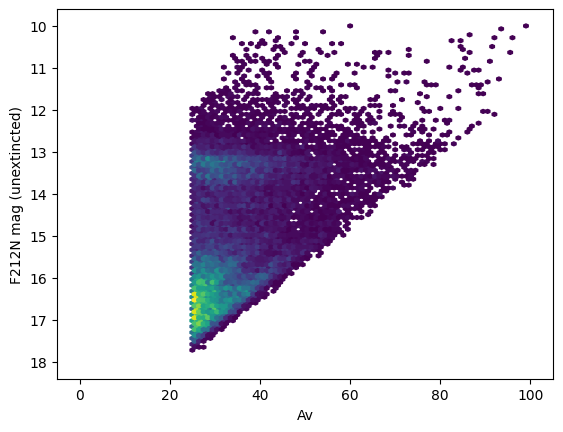

In [120]:

ax = plt.subplot(111)
plt.hexbin(cat_red.catalog['Av'], cat_red.catalog['f212n_mag_unextincted'], gridsize=100, mincnt=1, extent=(0, 100, 10, 18))
plt.gca().invert_yaxis()
plt.xlabel('Av')
plt.ylabel('F212N mag (unextincted)')


In [121]:
cat_use.catalog['f212n_mag_unextincted'] = unextinct_mag_212(cat_use, CT06_MWGC(), 'f212n', cat_use.catalog['Av'])

## Determine the faintest magnitude you detect in F212N

In [122]:
np.nanmax(cat_red.catalog['f212n_mag_unextincted'])

17.73041878656195

## Count the number of stars in the foreground 

(A_V < 25, but still A_V > 17 so they’re in the CMZ) that have mag < threshold, where threshold = faintest magnitude

In [123]:
cat_cmz = JWSTCatalog(cat_use.catalog[(cat_use.catalog['Av'] < red_lim) & (cat_use.catalog['Av'] > blue_lim) & (cat_use.catalog['f212n_mag_unextincted'] < np.nanmax(cat_red.catalog['f212n_mag_unextincted']))])

In [124]:
len(cat_cmz.catalog)

32145

## Account for saturated stars

deredden to 17th mag (you could do that by dereddening, then reddening back to 17th), reject that star from the background population if it is brighter than our saturation limit - which is M=15, roughly

In [173]:
from dust_extinction.averages import F11_MWGC, RL85_MWGC, RRP89_MWGC, G21_MWAvg
ext = CT06_MWGC() # RL85_MWGC() # F11_MWGC() # CT06_MWGC()

cat_red.catalog['f212n_mag_Av17'] = unextinct_mag(cat_red, ext, 'f212n', cat_red.catalog['Av'] - blue_lim) # blue_lim
cat_red_nosat = JWSTCatalog(cat_red.catalog[cat_red.catalog['f212n_mag_Av17'] > 14.3])

Text(0, 0.5, 'F212N mag (unextincted to Av=17)')

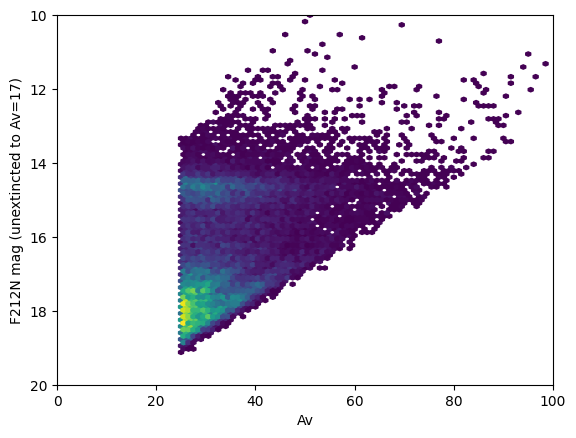

In [174]:
plt.hexbin(cat_red.catalog['Av'], cat_red.catalog['f212n_mag_Av17'], gridsize=100, mincnt=1, extent=(0, 100, 10, 20))
plt.gca().invert_yaxis()
plt.ylim(20, 10)
plt.xlim(0, 100)
plt.xlabel('Av')
plt.ylabel('F212N mag (unextincted to Av=17)')

Text(0.5, 1.0, '> 14.3')

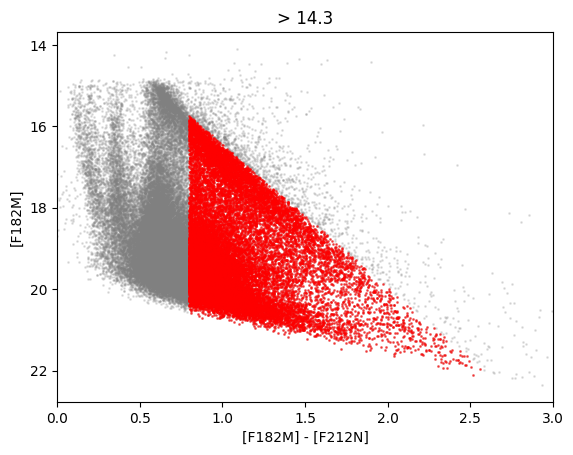

In [175]:
cat_use.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.2, color='gray')
cat_red_nosat.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='r')
plt.gca().invert_yaxis()
plt.xlim(0, 3)
plt.title('> 14.3')

# Find avg of leftmost area in front and replace pixels with values less than its square root with avg - front

In [176]:
cat_leftmost = JWSTCatalog(cat_cmz.table_region_mask(reg_left, ww))

<WCSAxes: >

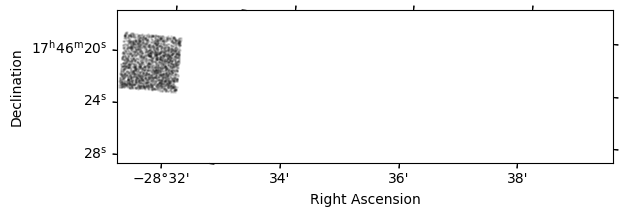

In [177]:
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_leftmost.plot_position(ax=ax, s=1, color='k', alpha=0.1, transform=ax.get_transform('world'))

## “Depth” = n_foreground / (n_back + n_fore), where both n_fore and n_back are the magnitude-limited sample

In [178]:
depth = len(cat_cmz.catalog) / (len(cat_red_nosat.catalog) + len(cat_cmz.catalog))
depth

0.5843695462478184

## Make images of this effective depth in various bin sizes (5”, 2.5”, 10”, whatever)

In [179]:
# for bin size 2.5 arcsec
dx = 2.5*u.arcsec
h_fore25 = star_density_color(cat_cmz.catalog, ww, dx=dx)
h_left25 = star_density_color(cat_leftmost.catalog, ww, dx=dx)
h_left25[h_left25==0] = np.nan
avg_left25 = np.nanmean(h_left25)
h_back25 = star_density_color(cat_red_nosat.catalog, ww, dx=dx)
#h_back25[h_back25<=1] = 6 - h_fore25[h_back25<=1]
h_back25[h_back25<=np.sqrt(avg_left25)] = avg_left25 - h_fore25[h_back25<=np.sqrt(avg_left25)]

h_depth25 = h_fore25 / (h_fore25 + h_back25)

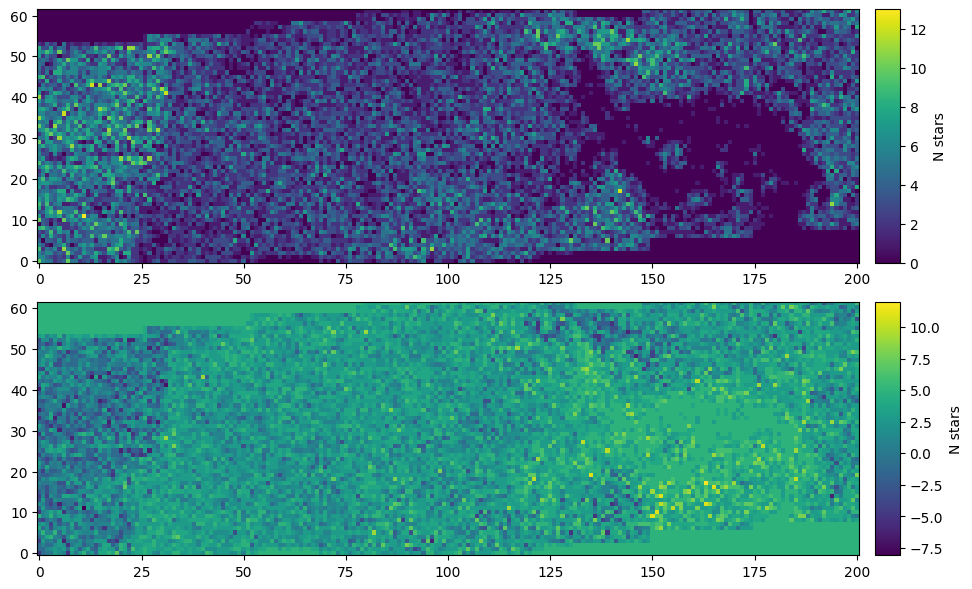

In [180]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
im = ax.imshow(h_fore25, origin='lower')
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N stars', cax=cbar)

ax = fig.add_subplot(212)
im = ax.imshow(h_back25, origin='lower')
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N stars', cax=cbar)

plt.tight_layout()

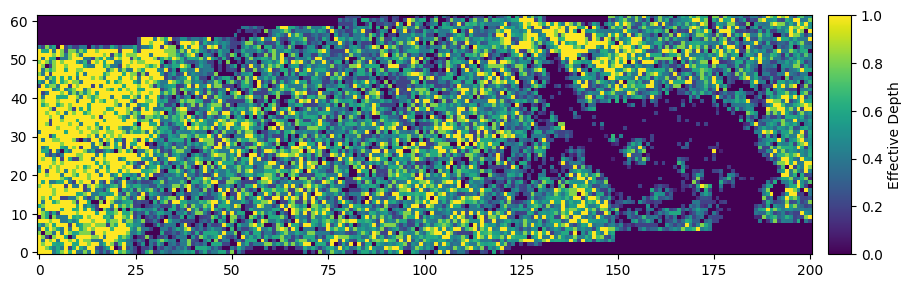

In [181]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth25, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

In [182]:
# for bin size 5 arcsec
dx = 5*u.arcsec
h_fore5 = star_density_color(cat_cmz.catalog, ww, dx=dx)
h_left5 = star_density_color(cat_leftmost.catalog, ww, dx=dx)
h_left5[h_left5==0] = np.nan
avg_left5 = np.nanmean(h_left5)
#h_fore5[h_fore5 == 0] = np.nan
h_back5 = star_density_color(cat_red_nosat.catalog, ww, dx=dx)
h_back5[h_back5<=np.sqrt(avg_left5)] = avg_left5 - h_fore5[h_back5<=np.sqrt(avg_left5)]
#h_back5[h_back5==25] = np.nan

h_depth5 = h_fore5 / (h_fore5 + h_back5)

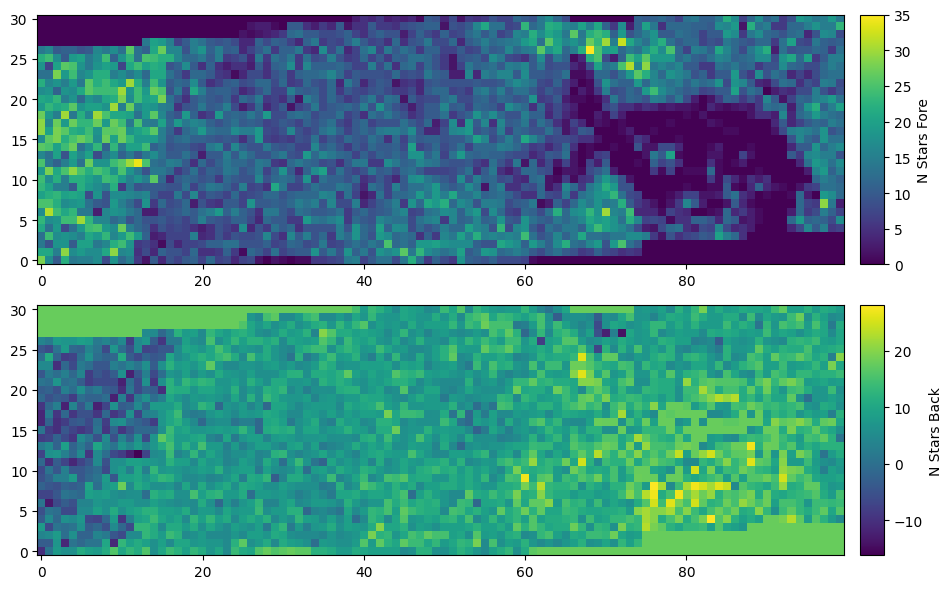

In [183]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
im = ax.imshow(h_fore5, origin='lower')#, vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N Stars Fore', cax=cbar)

ax = fig.add_subplot(212)
im = ax.imshow(h_back5, origin='lower')#, vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N Stars Back', cax=cbar)

plt.tight_layout()

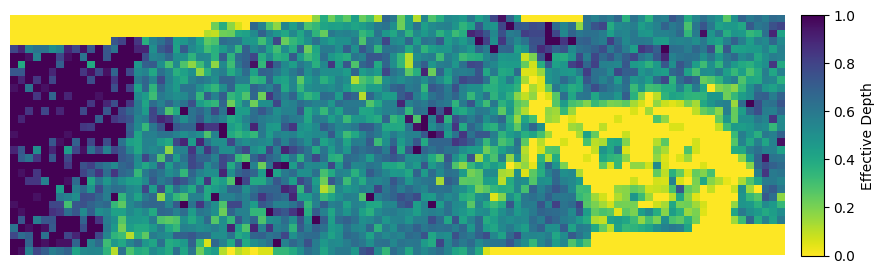

In [184]:
fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(111, projection=new_wcs)
#im = ax.imshow(np.flip(h_depth5, axis=1).swapaxes(0,1), origin='lower', vmin=0, vmax=1)
ax = fig.add_subplot(111)
im = ax.imshow(h_depth5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/effective_depth_5arcsec.png', dpi=300)
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/effective_depth_5arcsec.pdf', bbox_inches='tight')

In [168]:
h_depth5_copy = h_depth5.copy()
np.nanmean(h_depth5_copy)

0.5099616412157333

In [49]:
np.nansum(h_depth5), np.nansum(h_fore5), np.nansum(h_back5)

(1354.5124740535384, 31771.0, 38639.0)

In [50]:
np.nansum(h_fore5) / (np.nansum(h_fore5) + np.nansum(h_back5))

0.4512285186763244

In [51]:
#data_h_depth5 = fits.PrimaryHDU(np.flip(h_depth5, axis=1).swapaxes(0,1), header=new_wcs.to_header())
#data_h_depth5.writeto('/orange/adamginsburg/jwst/cloudc/images/effective_depth_5arcsec.fits', overwrite=True)

In [75]:
# for bin size of 10 arcsec
dx = 10*u.arcsec
h_fore10 = star_density_color(cat_cmz.catalog, ww, dx=dx)
h_left10 = star_density_color(cat_leftmost.catalog, ww, dx=dx)
h_left10[h_left10==0] = np.nan
avg_left10 = np.nanmean(h_left10)
h_back10 = star_density_color(cat_red_nosat.catalog, ww, dx=dx)
h_back10[h_back10<=np.sqrt(avg_left10)] = avg_left10 - h_fore10[h_back10<=np.sqrt(avg_left10)]

h_depth10 = h_fore10 / (h_fore10 + h_back10)

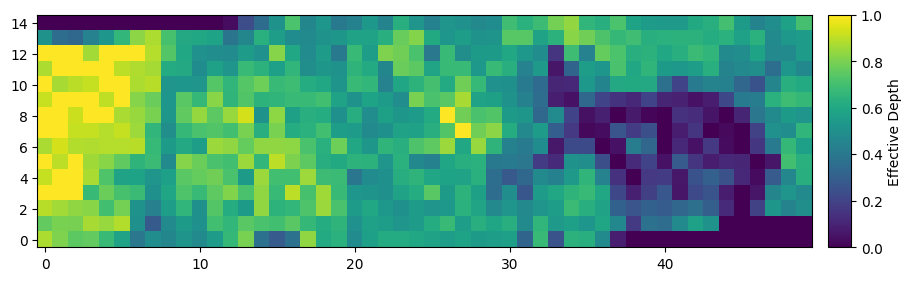

In [76]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth10, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

# Applying to Brick Data

In [38]:
cat_brick = make_brick_cat()

Reading /orange/adamginsburg/jwst/brick/catalogs/basic_merged_indivexp_photometry_tables_merged_qualcuts_oksep2221.fits


In [39]:
cat_brick.catalog['Av'] = cat_brick.get_Av('f182m', 'f212n')
cat_brick_red = JWSTCatalog(cat_brick.catalog[cat_brick.catalog['Av'] > 25])
cat_brick_red.catalog['f212n_mag_unextincted'] = unextinct_mag(cat_brick_red, CT06_MWGC(), 'f212n', cat_brick_red.catalog['Av'])
cat_brick_red_nosat = JWSTCatalog(cat_brick_red.catalog[cat_brick_red.catalog['f212n_mag_unextincted'] > 14.5])

cat_brick.catalog['f212n_mag_unextincted'] = unextinct_mag(cat_brick, CT06_MWGC(), 'f212n', cat_brick.catalog['Av'])

In [40]:
cat_brick_cmz = JWSTCatalog(cat_brick.catalog[(cat_brick.catalog['Av'] < 25) & (cat_brick.catalog['Av'] > 17) & (cat_brick.catalog['f212n_mag_unextincted'] < np.nanmax(cat_brick_red.catalog['f212n_mag_unextincted']))])

In [41]:
depth = len(cat_brick_cmz.catalog) / (len(cat_brick_red_nosat.catalog) + len(cat_brick_cmz.catalog))
depth

0.7679866373339852

In [42]:
hdu_brick = fits.open('/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')
ww_brick = WCS(hdu_brick['SCI'].header)

In [43]:
dx = 2.5*u.arcsec
h_fore25_brick = star_density_color(cat_brick_cmz.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))
h_back25_brick = star_density_color(cat_brick_red_nosat.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))

h_depth25_brick = h_fore25_brick / (h_fore25_brick + h_back25_brick)

/scratch/local/21278799/ipykernel_1601973/2398658562.py:5: RuntimeWarning: invalid value encountered in divide
  h_depth25_brick = h_fore25_brick / (h_fore25_brick + h_back25_brick)


In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth25_brick, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

In [ ]:
dx = 5*u.arcsec
h_fore5_brick = star_density_color(cat_brick_cmz.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))
h_back5_brick = star_density_color(cat_brick_red_nosat.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))

h_depth5_brick = h_fore5_brick / (h_fore5_brick + h_back5_brick)

/scratch/local/20796528/ipykernel_197336/1591192443.py:5: RuntimeWarning: invalid value encountered in divide
  h_depth5_brick = h_fore5_brick / (h_fore5_brick + h_back5_brick)


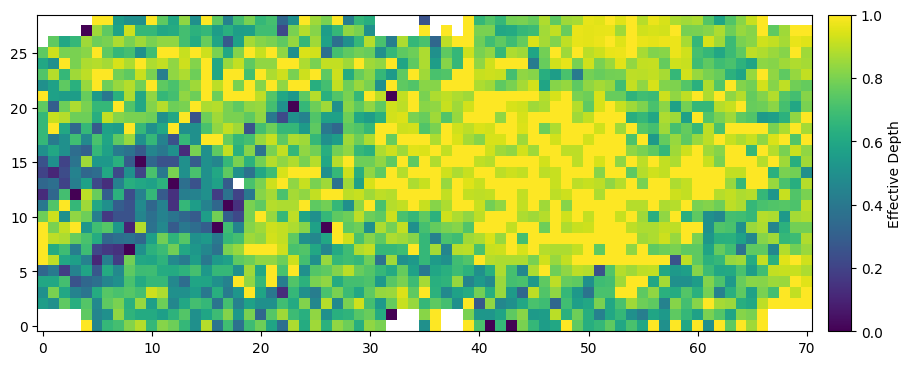

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth5_brick, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

In [ ]:
dx = 10*u.arcsec
h_fore10_brick = star_density_color(cat_brick_cmz.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))
h_back10_brick = star_density_color(cat_brick_red_nosat.catalog, ww_brick, dx=dx, size=(2.5*u.arcmin, 6*u.arcmin))

h_depth10_brick = h_fore10_brick / (h_fore10_brick + h_back10_brick)

/scratch/local/20796528/ipykernel_197336/357205845.py:5: RuntimeWarning: invalid value encountered in divide
  h_depth10_brick = h_fore10_brick / (h_fore10_brick + h_back10_brick)


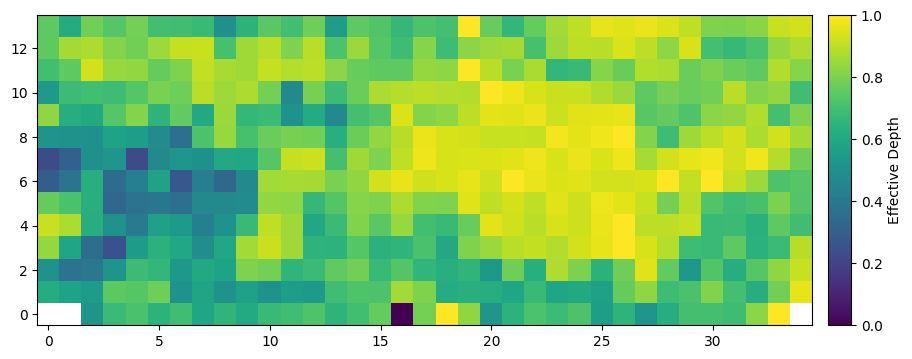

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth10_brick, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

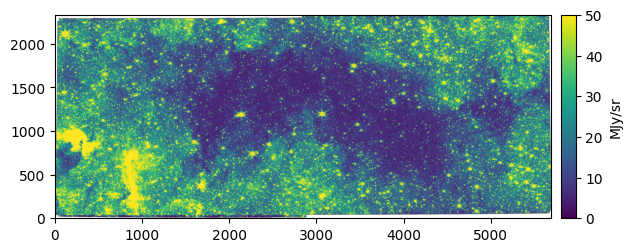

In [ ]:
ax = plt.subplot(111)
im = ax.imshow(hdu_brick['SCI'].data, origin='lower', vmin=0, vmax=50)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='MJy/sr', cax=cbar)

# Now using CO ice cut

## Select for stars behind CO ice

In [ ]:
f405mf466 = 0
f182mf212 = 0.8

mask_ice = ( (cat_use.color('f405n', 'f466n') < f405mf466) & (cat_use.color('f182m', 'f212n') > f182mf212) )
cat_ice = JWSTCatalog(cat_use.catalog[mask_ice])
mask_noice = ~mask_ice & (cat_use.color('f182m', 'f212n') > 0.5)
cat_noice = JWSTCatalog(cat_use.catalog[mask_noice])

In [ ]:
pt1 = (0.6, -0.5)
pt2 = (.9, 0)
y = (pt2[1]-pt1[1])/(pt2[0]-pt1[0]) * (cat_use.color('f182m', 'f212n') - pt1[0]) + pt1[1]
mask_above_line = cat_use.color('f405n', 'f466n') < y
cat_ice_final = JWSTCatalog(cat_use.catalog[mask_above_line])
cat_ice_front = JWSTCatalog(cat_use.catalog[~mask_above_line & (cat_use.color('f182m', 'f212n') > 0.5)])

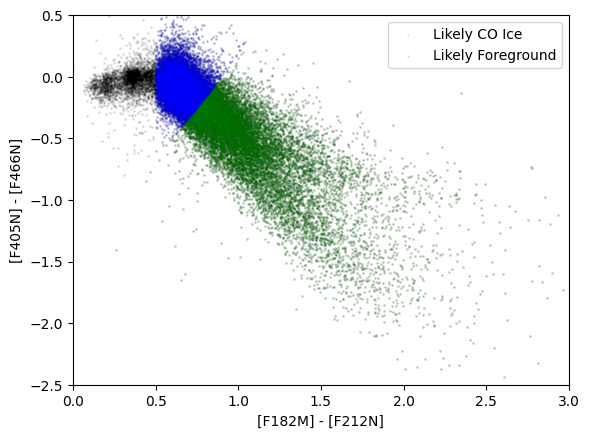

In [ ]:
ax = plt.subplot(111)
cat_use.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='k', alpha=0.1, s=1, ax=ax)
#cat_ice.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='b', alpha=0.1, s=1, ax=ax, label='Behind CO Ice')
#ax = plt.subplot(122)
#cat_noice.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='r', alpha=0.1, s=1, ax=ax, label='"No" CO Ice')
cat_ice_final.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='g', alpha=0.1, s=1, ax=ax, label='Likely CO Ice')
cat_ice_front.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='b', alpha=0.1, s=1, ax=ax, label='Likely Foreground')

ax.set_xlim(0, 3)
ax.set_ylim(-2.5, 0.5)
plt.legend()

## Measure Depth

In [ ]:
depth = len(cat_ice_front.catalog) / (len(cat_ice_final.catalog) + len(cat_ice_front.catalog))
depth

0.6783290445879042

## Make images

In [ ]:
# for bin size 2.5 arcsec
dx = 2.5*u.arcsec
h_fore25_ice = star_density_color(cat_ice_front.catalog, ww, dx=dx)
h_back25_ice = star_density_color(cat_ice_final.catalog, ww, dx=dx)

h_depth25_ice = h_fore25_ice / (h_fore25_ice + h_back25_ice)

/scratch/local/20796528/ipykernel_197336/1971393556.py:6: RuntimeWarning: invalid value encountered in divide
  h_depth25_ice = h_fore25_ice / (h_fore25_ice + h_back25_ice)


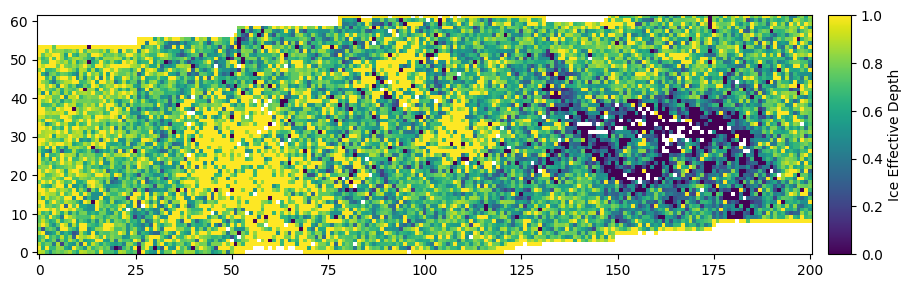

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth25_ice, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Ice Effective Depth', cax=cbar)

In [ ]:
# for bin size 5 arcsec
dx = 5*u.arcsec
h_fore5_ice = star_density_color(cat_ice_front.catalog, ww, dx=dx)
h_back5_ice = star_density_color(cat_ice_final.catalog, ww, dx=dx)

h_depth5_ice = h_fore5_ice / (h_fore5_ice + h_back5_ice)

/scratch/local/20796528/ipykernel_197336/2146973251.py:6: RuntimeWarning: invalid value encountered in divide
  h_depth5_ice = h_fore5_ice / (h_fore5_ice + h_back5_ice)


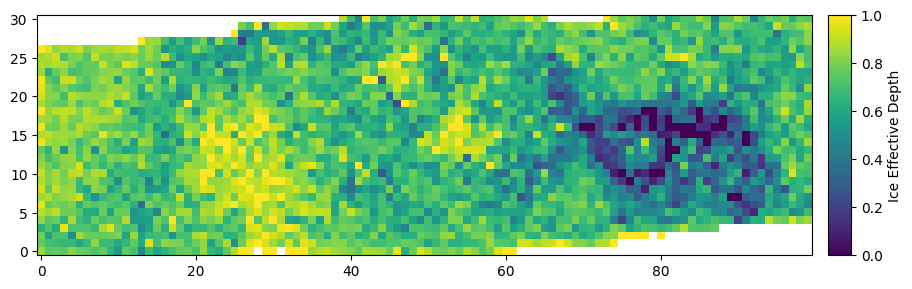

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth5_ice, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Ice Effective Depth', cax=cbar)

In [ ]:
# for bin size 10 arcsec
dx = 10*u.arcsec
h_fore10_ice = star_density_color(cat_ice_front.catalog, ww, dx=dx)
h_back10_ice = star_density_color(cat_ice_final.catalog, ww, dx=dx)

h_depth10_ice = h_fore10_ice / (h_fore10_ice + h_back10_ice)

/scratch/local/20796528/ipykernel_197336/998937494.py:6: RuntimeWarning: invalid value encountered in divide
  h_depth10_ice = h_fore10_ice / (h_fore10_ice + h_back10_ice)


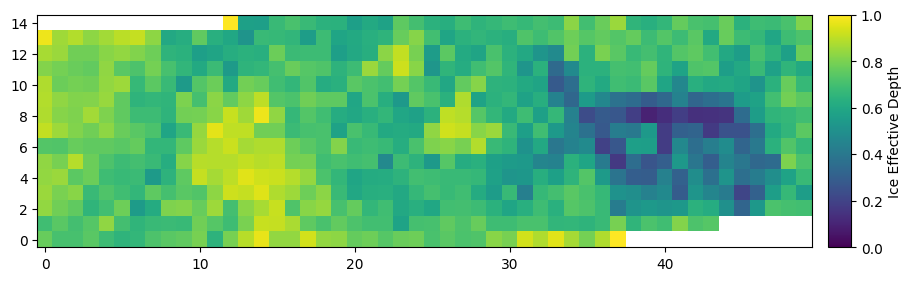

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth10_ice, origin='lower', vmin=0, vmax=1)
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Ice Effective Depth', cax=cbar)

In [ ]:
# /orange/adamginsburg/ACES/mosaics/cubes/CS21_CubeMosaic.fits

# For RC Stars

In [86]:
def get_rc_sel_mask(cat):
    x = np.linspace(0, 2.5, 10)
    
    x0 = 0.52
    mask_x0_left = cat.color('f182m', 'f212n') > x0

    y0 = 14.8
    mask_above_y0 = cat.band('f182m') > y0
    mask_rc = mask_above_y0 & mask_x0_left

    pt1 = (0.5, 14.3)
    pt2 = (2.0, 20.)
    y1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_below_y1 = cat.band('f182m') > ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_below_y1 & mask_rc

    pt1 = (0.5, 15.5)
    pt2 = (2.0, 20.9)
    y2 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_above_y2 = cat.band('f182m') < ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_rc & mask_above_y2

    return mask_rc

mask_rc = get_rc_sel_mask(cat_use)
cat_rc = JWSTCatalog(cat_use.catalog[mask_rc])

In [92]:
cat_rc.catalog['Av'] = cat_rc.get_Av('f182m', 'f212n')
cat_rc_red = JWSTCatalog(cat_rc.catalog[cat_rc.catalog['Av'] > 25])
cat_rc_red.catalog['f212n_mag_unextincted'] = unextinct_mag(cat_rc_red, CT06_MWGC(), 'f212n', cat_rc_red.catalog['Av'])
cat_rc_red_nosat = JWSTCatalog(cat_rc_red.catalog[cat_rc_red.catalog['f212n_mag_unextincted'] > 14.5])
cat_leftmost_rc = JWSTCatalog(cat_rc.table_region_mask(reg_left, ww))

cat_rc.catalog['f212n_mag_unextincted'] = unextinct_mag(cat_rc, CT06_MWGC(), 'f212n', cat_rc.catalog['Av'])

In [88]:
cat_rc_cmz = JWSTCatalog(cat_rc.catalog[(cat_rc.catalog['Av'] < 25) & (cat_rc.catalog['Av'] > 17) & (cat_rc.catalog['f212n_mag_unextincted'] < np.nanmax(cat_rc_red.catalog['f212n_mag_unextincted']))])

In [93]:
dx = 5*u.arcsec
h_fore5_rc = star_density_color(cat_rc_cmz.catalog, ww, dx=dx)
h_left5_rc = star_density_color(cat_leftmost_rc.catalog, ww, dx=dx)
h_left5_rc[h_left5_rc==0] = np.nan
avg_left5_rc = np.nanmean(h_left5_rc)
h_back5_rc = star_density_color(cat_rc_red_nosat.catalog, ww, dx=dx)
h_back5_rc[h_back5_rc<=np.sqrt(avg_left5_rc)] = avg_left5_rc - h_fore5_rc[h_back5_rc<=np.sqrt(avg_left5_rc)]
#h_back5_rc = star_density_color(cat_rc_red.catalog, ww, dx=dx)

h_depth5_rc = h_fore5_rc / (h_fore5_rc + h_back5_rc)

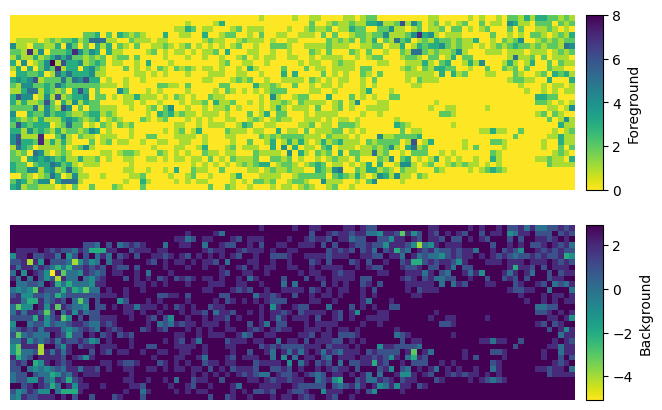

In [94]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(211)
im = ax.imshow(h_fore5_rc, origin='lower', cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Foreground', cax=cbar)

ax = fig.add_subplot(212)
im = ax.imshow(h_back5_rc, origin='lower', cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Background', cax=cbar)

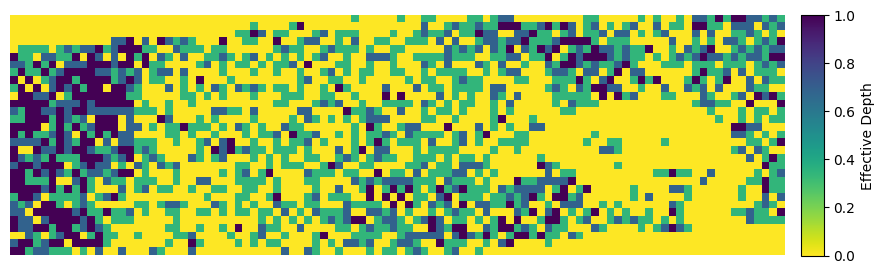

In [95]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth5_rc, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

In [96]:
dx = 10*u.arcsec
h_fore10_rc = star_density_color(cat_rc_cmz.catalog, ww, dx=dx)
h_left10_rc = star_density_color(cat_leftmost_rc.catalog, ww, dx=dx)
h_left10_rc[h_left10_rc==0] = np.nan
avg_left10_rc = np.nanmean(h_left10_rc)
h_back10_rc = star_density_color(cat_rc_red_nosat.catalog, ww, dx=dx)
h_back10_rc[h_back10_rc<=np.sqrt(avg_left10_rc)] = avg_left10_rc - h_fore10_rc[h_back10_rc<=np.sqrt(avg_left10_rc)]
# h_back10_rc = star_density_color(cat_rc_red.catalog, ww, dx=dx)

h_depth10_rc = h_fore10_rc / (h_fore10_rc + h_back10_rc)

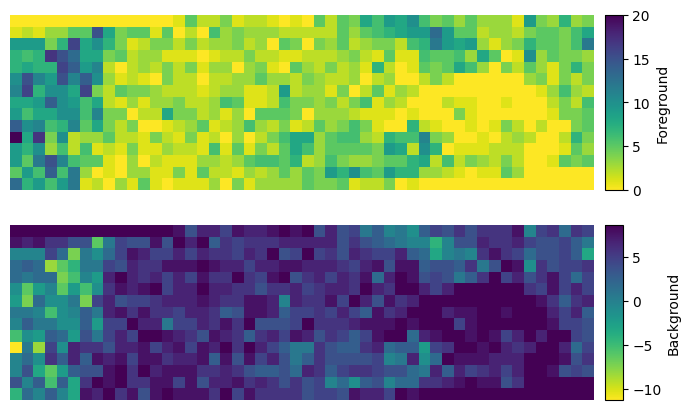

In [97]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(211)
im = ax.imshow(h_fore10_rc, origin='lower', cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Foreground', cax=cbar)

ax = fig.add_subplot(212)
im = ax.imshow(h_back10_rc, origin='lower', cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Background', cax=cbar)

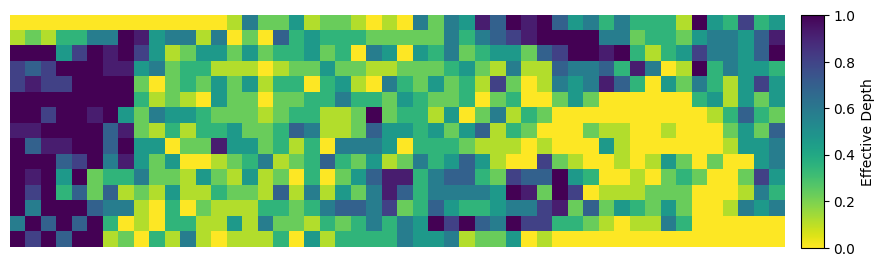

In [98]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(h_depth10_rc, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
ax.set_axis_off()
cbar = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Effective Depth', cax=cbar)

# Alternate

In [260]:
def make_foreground(cat, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC()):
    cat.catalog['Av'] = cat.get_Av(band1, band2, ext)
    cat.catalog['f212n_mag_unextincted'] = unextinct_mag_212(cat, ext, 'f212n', cat.catalog['Av'])
    cat_fg = JWSTCatalog(cat.catalog[(cat.catalog['Av'] < red_limit) & (cat.catalog['Av'] > blue_limit) & (cat.catalog['f212n_mag_unextincted'] < np.nanmax(cat.catalog['f212n_mag_unextincted']))])
    #cat_fg_nosat = JWSTCatalog(cat_fg.catalog[cat_fg.catalog['f212n_mag_unextincted'] > 14.5])
    return cat_fg

def make_background(cat, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC()):
    cat.catalog['Av'] = cat.get_Av(band1, band2, ext)
    cat_bg = JWSTCatalog(cat.catalog[cat.catalog['Av'] > red_limit])
    cat_bg.catalog['f212n_mag_unextincted'] = unextinct_mag_212(cat_bg, ext, 'f212n', cat_bg.catalog['Av'])
    extincted_bluelim = unextinct_mag_212(cat_bg, ext, 'f212n', cat_bg.catalog['Av'] - blue_limit)
    cat_bg_nosat = JWSTCatalog(cat_bg.catalog[extincted_bluelim > 14.3])
    return cat_bg_nosat

def make_total_map(cat, ww, dx=5*u.arcsec, size=(2.6*u.arcmin, 8.4*u.arcmin)):
    h_total = star_density_color(cat.catalog, ww, dx=dx, size=size)
    return h_total

def make_foreground_map(cat, ww, dx=5*u.arcsec, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC(), size=(2.6*u.arcmin, 8.4*u.arcmin)):
    cat_fg = make_foreground(cat, band1, band2, blue_limit, red_limit, ext)
    h_fore = star_density_color(cat_fg.catalog, ww, dx=dx)
    return h_fore

def make_left_correction_map(cat, ww, dx=5*u.arcsec, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC(), size=(2.6*u.arcmin, 8.4*u.arcmin)):
    fore = make_foreground(cat, band1, band2, blue_limit, red_limit, ext)
    left = JWSTCatalog(fore.table_region_mask(reg_left, ww))
    h_left = star_density_color(left.catalog, ww, dx=dx, size=size)
    h_left[h_left==0] = np.nan
    return h_left

def make_background_map(cat, ww, cat_tot=cat_use, dx=5*u.arcsec, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC(), size=(2.6*u.arcmin, 8.4*u.arcmin)):
    cat_bg = make_background(cat, band1, band2, blue_limit, red_limit, ext)
    h_back = star_density_color(cat_bg.catalog, ww, dx=dx, size=size)
    h_fore = make_foreground_map(cat, ww, dx, band1, band2, blue_limit, red_limit, ext, size=size)
    h_left = make_left_correction_map(cat_tot, ww, dx, band1, band2, blue_limit, red_limit, ext, size=size)
    avg_left = np.nanmean(h_left)
    h_back[h_back<=np.sqrt(avg_left)] = avg_left - h_fore[h_back<=np.sqrt(avg_left)]
    return h_back

def make_effective_depth_map(cat, ww, cat_tot=cat_use, dx=5*u.arcsec, band1='f182m', band2='f212n', blue_limit=17, red_limit=25, ext=CT06_MWGC(), size=(2.6*u.arcmin, 8.4*u.arcmin)):
    h_fore = make_foreground_map(cat, ww, dx, band1, band2, blue_limit, red_limit, ext, size=size)
    h_back = make_background_map(cat, ww, cat_tot, dx, band1, band2, blue_limit, red_limit, ext, size=size)
    h_total = make_total_map(cat, ww, dx, size=size)
    h_depth = h_fore / (h_fore + h_back)
    h_depth[h_total==0] = np.nan
    return h_depth


(0.0, 3.0)

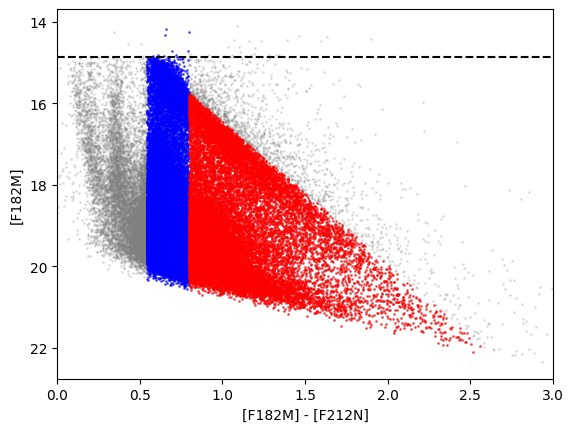

In [187]:
cat_use.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.2, color='gray')
fore.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='b')
back.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='r')
#plt.gca().invert_yaxis()
plt.axhline(14.85, color='k', linestyle='--')

plt.xlim(0, 3)

In [188]:
h_fore5 = make_foreground_map(cat_use, ww, dx=5*u.arcsec)
h_back5 = make_background_map(cat_use, ww, dx=5*u.arcsec)

h_depth5 = h_fore5 / (h_fore5 + h_back5)

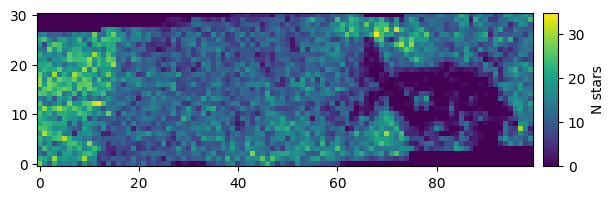

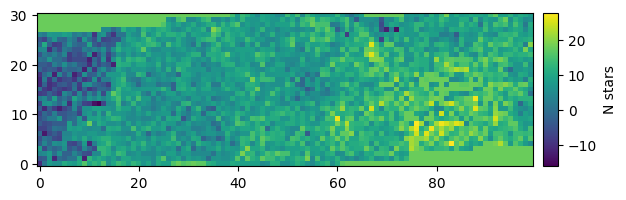

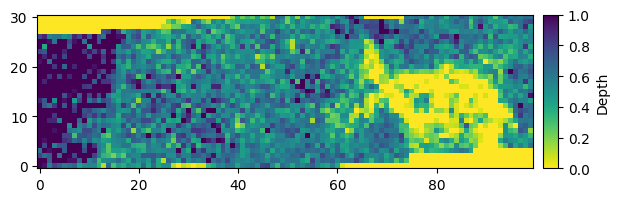

In [189]:
ax = plt.subplot(111)
im = ax.imshow(h_fore5, origin='lower')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N stars', cax=cax)
plt.show()

ax = plt.subplot(111)
im = ax.imshow(h_back5, origin='lower')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='N stars', cax=cax)
plt.show()

ax = plt.subplot(111)
im = ax.imshow(h_depth5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
plt.show()

In [193]:
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, ww))
cat_c1 = JWSTCatalog(cat_use.table_region_mask(reg_c1, ww))
cat_c2 = JWSTCatalog(cat_use.table_region_mask(reg_c2, ww))
cat_d = JWSTCatalog(cat_use.table_region_mask(reg_d, ww))
cat_b = JWSTCatalog(cat_use.table_region_mask(reg_b, ww))

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/scratch/local/21406003/ipykernel_652534/3290981851.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/3290981851.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/3290981851.py:39: SyntaxWarning: invalid escape

0.5360364506627393
0.39448409551502334
0.554069157584055
0.5220453614497189


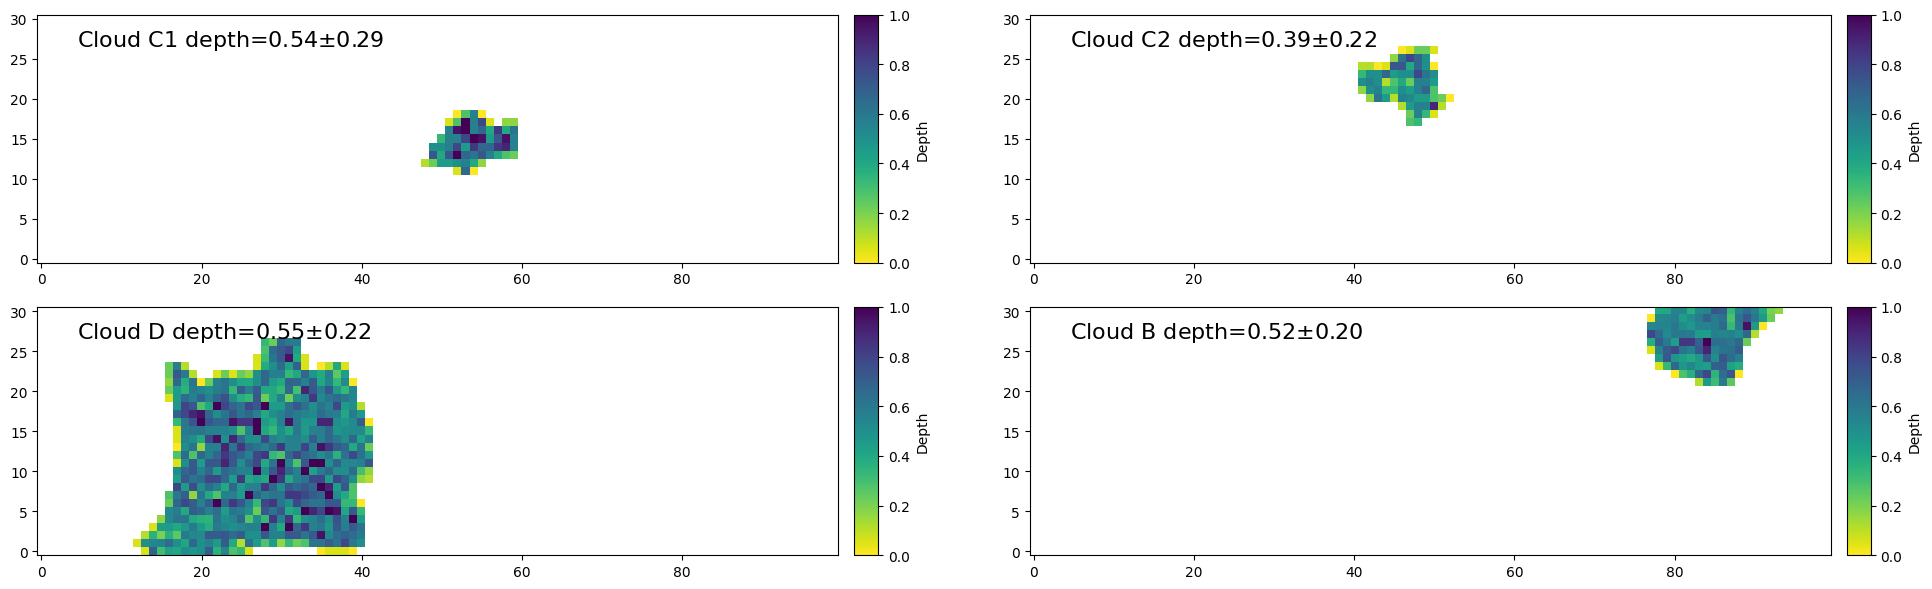

In [244]:
dx = 5*u.arcsec

fig = plt.figure(figsize=(20,6))

## Cloud C1
depth_c1_5 = make_effective_depth_map(cat_c1, ww, dx=dx)
mean_depth_c1_5 = np.nanmean(depth_c1_5)
std_depth_c1_5 = np.nanstd(depth_c1_5)
print(mean_depth_c1_5)

ax = plt.subplot(221)
im = ax.imshow(depth_c1_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud C2
depth_c2_5 = make_effective_depth_map(cat_c2, ww, dx=dx)
mean_depth_c2_5 = np.nanmean(depth_c2_5)
std_depth_c2_5 = np.nanstd(depth_c2_5)
print(mean_depth_c2_5)

ax = plt.subplot(222)
im = ax.imshow(depth_c2_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud D
depth_d_5 = make_effective_depth_map(cat_d, ww, dx=dx)
mean_depth_d_5 = np.nanmean(depth_d_5)
std_depth_d_5 = np.nanstd(depth_d_5)
print(mean_depth_d_5)

ax = plt.subplot(223)
im = ax.imshow(depth_d_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud D depth={mean_depth_d_5:.2f}$\pm${std_depth_d_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud B
depth_b_5 = make_effective_depth_map(cat_b, ww, dx=dx)
mean_depth_b_5 = np.nanmean(depth_b_5)
std_depth_b_5 = np.nanstd(depth_b_5)
print(mean_depth_b_5)

ax = plt.subplot(224)
im = ax.imshow(depth_b_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud B depth={mean_depth_b_5:.2f}$\pm${std_depth_b_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

plt.tight_layout()

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/scratch/local/21406003/ipykernel_652534/2068296751.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/2068296751.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/2068296751.py:39: SyntaxWarning: invalid escape

0.5616957330116821
0.4268022904075434
0.511408252636608
0.5172081219692597


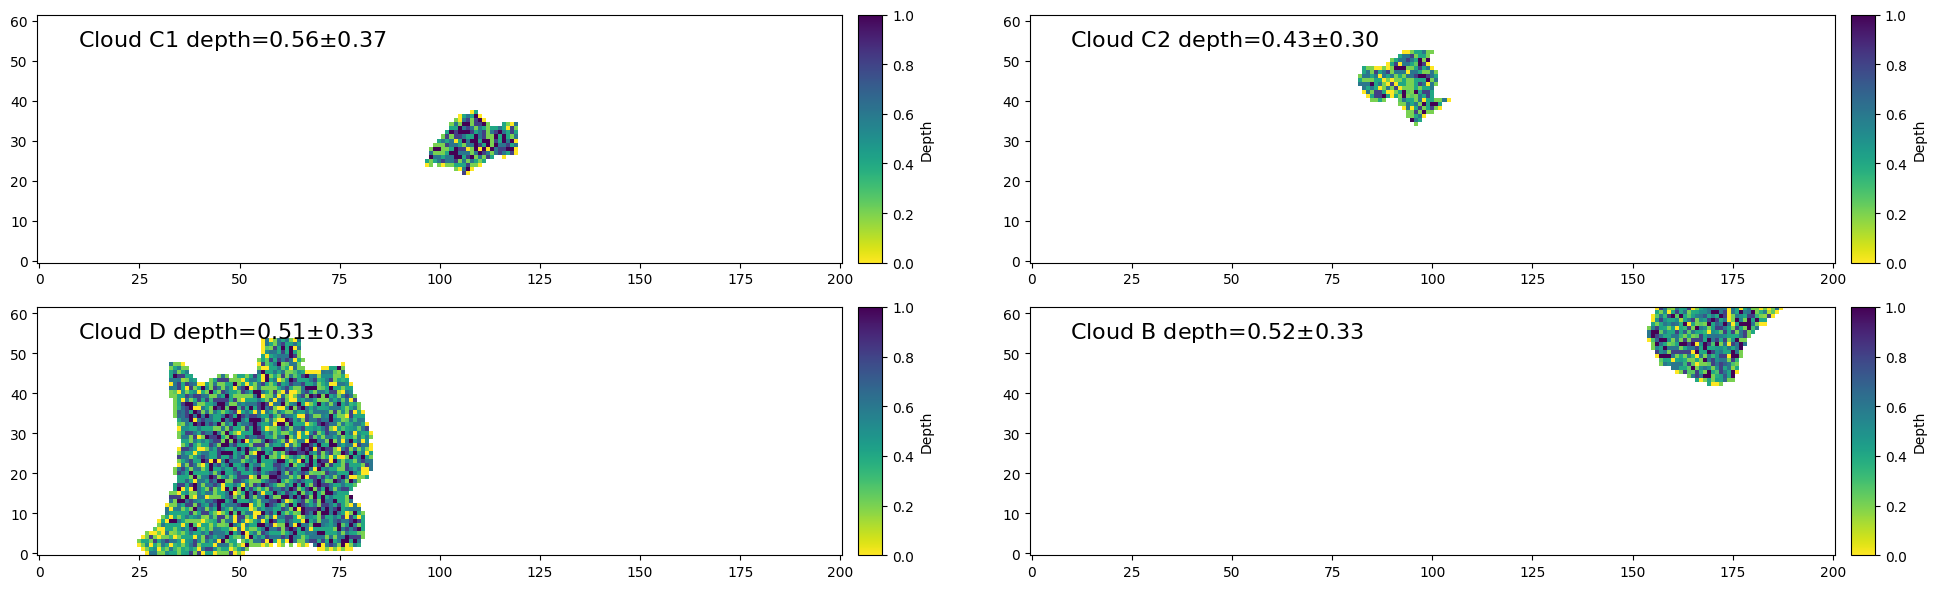

In [245]:
dx = 2.5*u.arcsec

fig = plt.figure(figsize=(20,6))

## Cloud C1
depth_c1_5 = make_effective_depth_map(cat_c1, ww, dx=dx)
mean_depth_c1_5 = np.nanmean(depth_c1_5)
std_depth_c1_5 = np.nanstd(depth_c1_5)
print(mean_depth_c1_5)

ax = plt.subplot(221)
im = ax.imshow(depth_c1_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud C2
depth_c2_5 = make_effective_depth_map(cat_c2, ww, dx=dx)
mean_depth_c2_5 = np.nanmean(depth_c2_5)
std_depth_c2_5 = np.nanstd(depth_c2_5)
print(mean_depth_c2_5)

ax = plt.subplot(222)
im = ax.imshow(depth_c2_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud D
depth_d_5 = make_effective_depth_map(cat_d, ww, dx=dx)
mean_depth_d_5 = np.nanmean(depth_d_5)
std_depth_d_5 = np.nanstd(depth_d_5)
print(mean_depth_d_5)

ax = plt.subplot(223)
im = ax.imshow(depth_d_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud D depth={mean_depth_d_5:.2f}$\pm${std_depth_d_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud B
depth_b_5 = make_effective_depth_map(cat_b, ww, dx=dx)
mean_depth_b_5 = np.nanmean(depth_b_5)
std_depth_b_5 = np.nanstd(depth_b_5)
print(mean_depth_b_5)

ax = plt.subplot(224)
im = ax.imshow(depth_b_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud B depth={mean_depth_b_5:.2f}$\pm${std_depth_b_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

plt.tight_layout()

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/scratch/local/21406003/ipykernel_652534/1105116173.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1105116173.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1105116173.py:39: SyntaxWarning: invalid escape

0.5219390986430268
0.3481423871703695
0.6190956464102428
0.4927599787742267


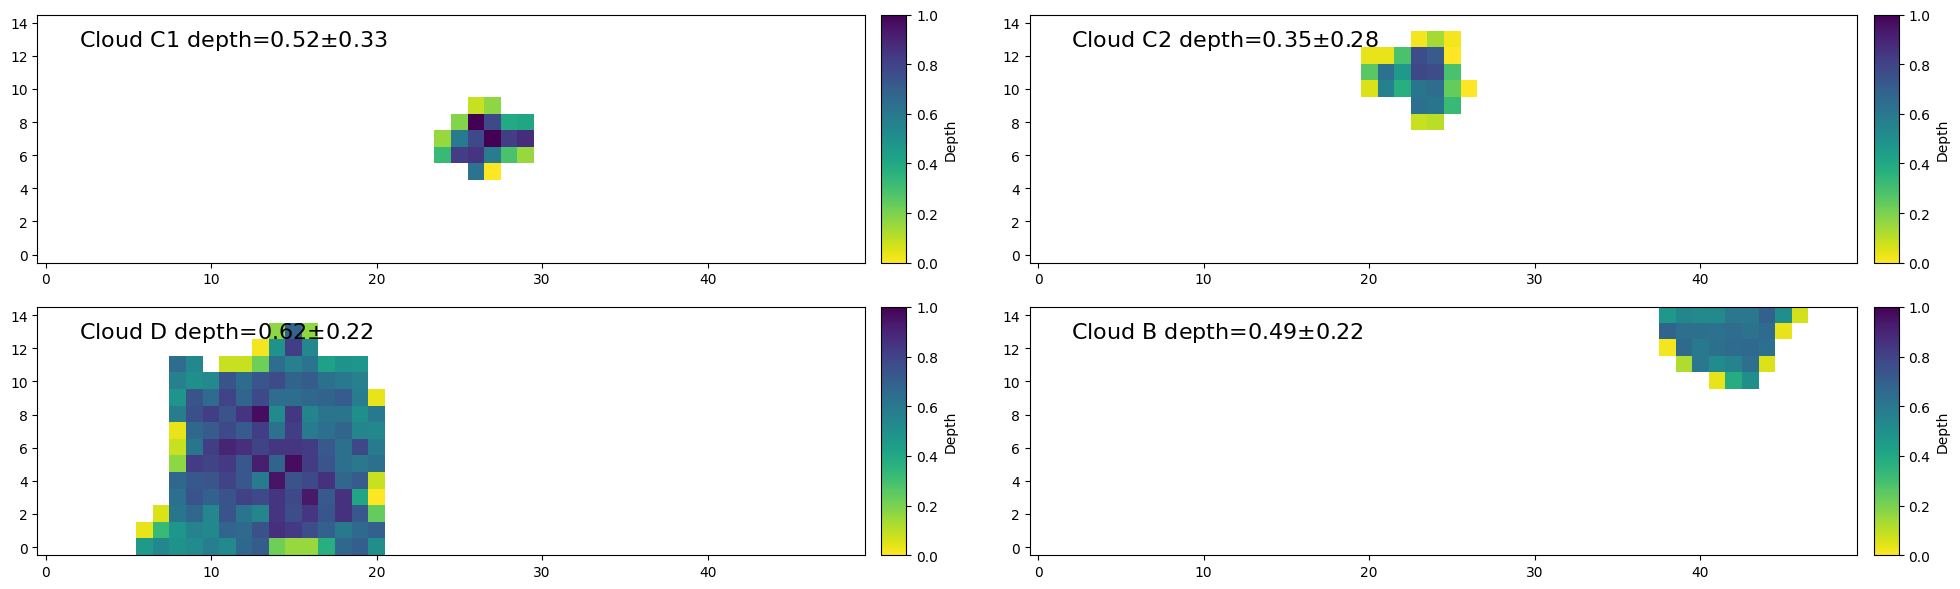

In [246]:
dx = 10*u.arcsec

fig = plt.figure(figsize=(20,6))

## Cloud C1
depth_c1_5 = make_effective_depth_map(cat_c1, ww, dx=dx)
mean_depth_c1_5 = np.nanmean(depth_c1_5)
std_depth_c1_5 = np.nanstd(depth_c1_5)
print(mean_depth_c1_5)

ax = plt.subplot(221)
im = ax.imshow(depth_c1_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud C2
depth_c2_5 = make_effective_depth_map(cat_c2, ww, dx=dx)
mean_depth_c2_5 = np.nanmean(depth_c2_5)
std_depth_c2_5 = np.nanstd(depth_c2_5)
print(mean_depth_c2_5)

ax = plt.subplot(222)
im = ax.imshow(depth_c2_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud D
depth_d_5 = make_effective_depth_map(cat_d, ww, dx=dx)
mean_depth_d_5 = np.nanmean(depth_d_5)
std_depth_d_5 = np.nanstd(depth_d_5)
print(mean_depth_d_5)

ax = plt.subplot(223)
im = ax.imshow(depth_d_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud D depth={mean_depth_d_5:.2f}$\pm${std_depth_d_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud B
depth_b_5 = make_effective_depth_map(cat_b, ww, dx=dx)
mean_depth_b_5 = np.nanmean(depth_b_5)
std_depth_b_5 = np.nanstd(depth_b_5)
print(mean_depth_b_5)

ax = plt.subplot(224)
im = ax.imshow(depth_b_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud B depth={mean_depth_b_5:.2f}$\pm${std_depth_b_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

plt.tight_layout()

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/scratch/local/21406003/ipykernel_652534/1550406800.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1550406800.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1550406800.py:39: SyntaxWarning: invalid escape

0.5404049059376587
0.4173149899929495
0.6612797751456531
0.4640959731774432


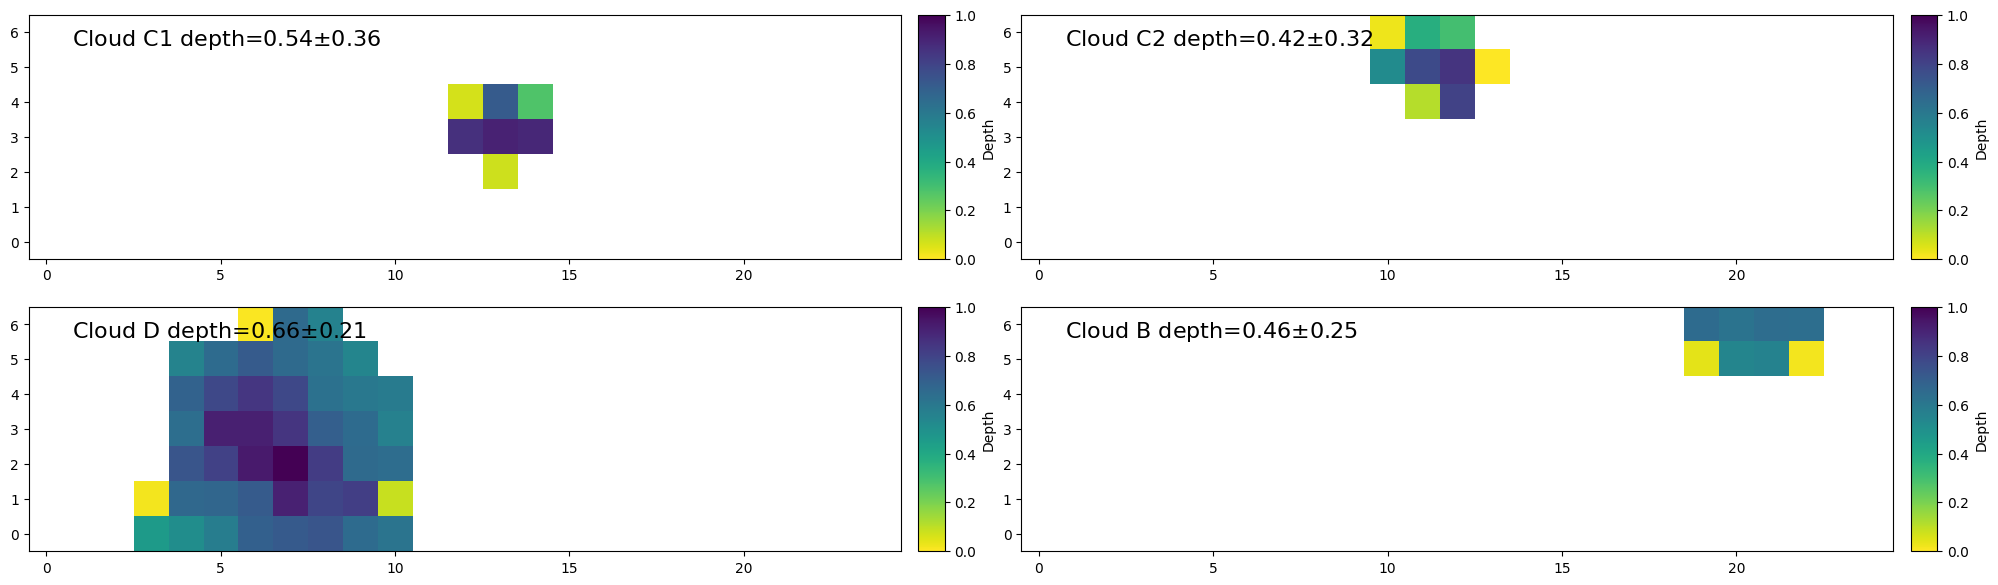

In [247]:
dx = 20*u.arcsec

fig = plt.figure(figsize=(20,6))

## Cloud C1
depth_c1_5 = make_effective_depth_map(cat_c1, ww, dx=dx)
mean_depth_c1_5 = np.nanmean(depth_c1_5)
std_depth_c1_5 = np.nanstd(depth_c1_5)
print(mean_depth_c1_5)

ax = plt.subplot(221)
im = ax.imshow(depth_c1_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud C2
depth_c2_5 = make_effective_depth_map(cat_c2, ww, dx=dx)
mean_depth_c2_5 = np.nanmean(depth_c2_5)
std_depth_c2_5 = np.nanstd(depth_c2_5)
print(mean_depth_c2_5)

ax = plt.subplot(222)
im = ax.imshow(depth_c2_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud D
depth_d_5 = make_effective_depth_map(cat_d, ww, dx=dx)
mean_depth_d_5 = np.nanmean(depth_d_5)
std_depth_d_5 = np.nanstd(depth_d_5)
print(mean_depth_d_5)

ax = plt.subplot(223)
im = ax.imshow(depth_d_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud D depth={mean_depth_d_5:.2f}$\pm${std_depth_d_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud B
depth_b_5 = make_effective_depth_map(cat_b, ww, dx=dx)
mean_depth_b_5 = np.nanmean(depth_b_5)
std_depth_b_5 = np.nanstd(depth_b_5)
print(mean_depth_b_5)

ax = plt.subplot(224)
im = ax.imshow(depth_b_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud B depth={mean_depth_b_5:.2f}$\pm${std_depth_b_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

plt.tight_layout()

<Axes: xlabel='[F182M] - [F212N]', ylabel='[F182M]'>

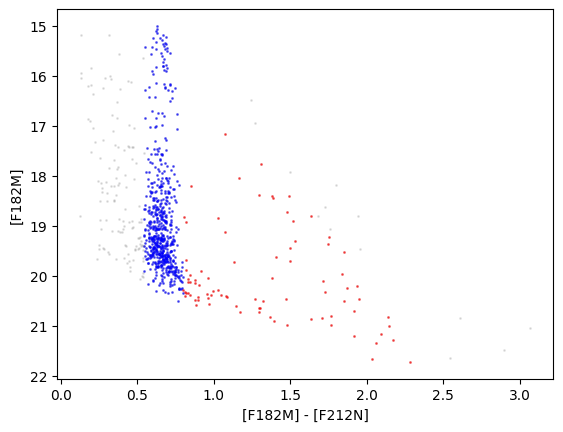

In [204]:
fore_c1 = make_foreground(cat_c1)
back_c1 = make_background(cat_c1)

cat_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.2, color='gray')
fore_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='b')
back_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='r')


## RC

In [258]:
cat_rc = JWSTCatalog(cat_use.catalog[get_rc_sel_mask(cat_use)])

cat_rc_c1 = JWSTCatalog(cat_rc.table_region_mask(reg_c1, ww))
cat_rc_c2 = JWSTCatalog(cat_rc.table_region_mask(reg_c2, ww))
cat_rc_d = JWSTCatalog(cat_rc.table_region_mask(reg_d, ww))
cat_rc_b = JWSTCatalog(cat_rc.table_region_mask(reg_b, ww))

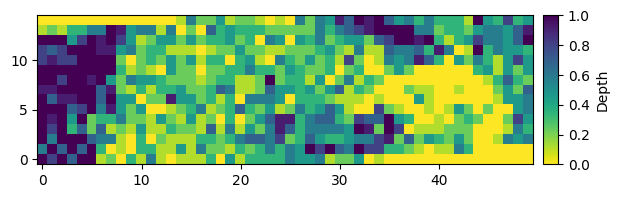

In [265]:
make_effective_depth_map(cat_rc, ww, cat_tot=cat_rc, dx=10*u.arcsec)
im = plt.imshow(h_depth10_rc, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = plt.gca().inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/scratch/local/21406003/ipykernel_652534/1510111807.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1510111807.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)
/scratch/local/21406003/ipykernel_652534/1510111807.py:39: SyntaxWarning: invalid escape

0.2690754664438875
0.23141735918744227
0.21061414586737326
0.23818447147394517


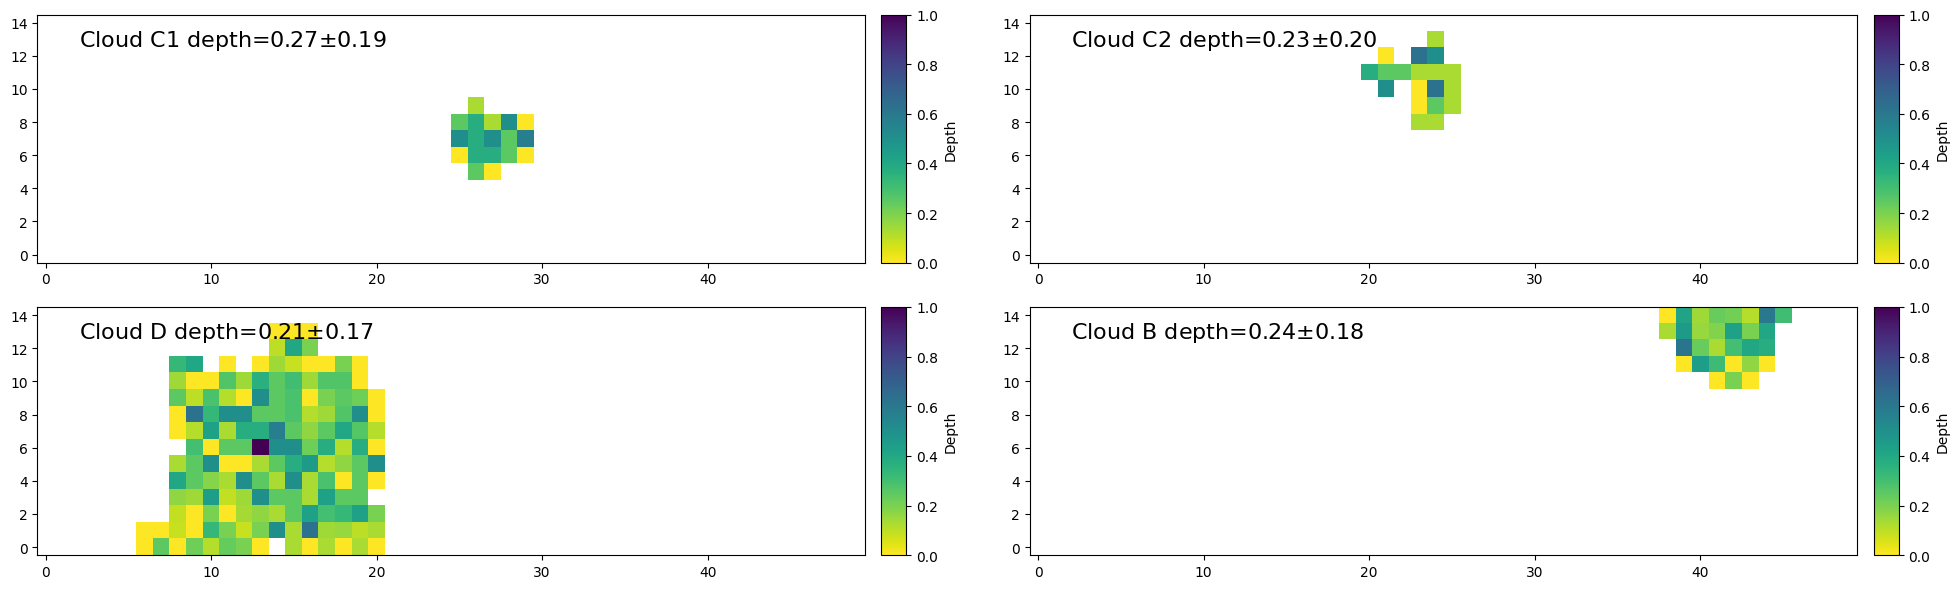

In [266]:
dx = 10*u.arcsec

fig = plt.figure(figsize=(20,6))

## Cloud C1
depth_c1_5 = make_effective_depth_map(cat_rc_c1, ww, cat_tot=cat_rc, dx=dx)
mean_depth_c1_5 = np.nanmean(depth_c1_5)
std_depth_c1_5 = np.nanstd(depth_c1_5)
print(mean_depth_c1_5)

ax = plt.subplot(221)
im = ax.imshow(depth_c1_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C1 depth={mean_depth_c1_5:.2f}$\pm${std_depth_c1_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud C2
depth_c2_5 = make_effective_depth_map(cat_rc_c2, ww, cat_tot=cat_rc, dx=dx)
mean_depth_c2_5 = np.nanmean(depth_c2_5)
std_depth_c2_5 = np.nanstd(depth_c2_5)
print(mean_depth_c2_5)

ax = plt.subplot(222)
im = ax.imshow(depth_c2_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud C2 depth={mean_depth_c2_5:.2f}$\pm${std_depth_c2_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud D
depth_d_5 = make_effective_depth_map(cat_rc_d, ww, cat_tot=cat_rc, dx=dx)
mean_depth_d_5 = np.nanmean(depth_d_5)
std_depth_d_5 = np.nanstd(depth_d_5)
print(mean_depth_d_5)

ax = plt.subplot(223)
im = ax.imshow(depth_d_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud D depth={mean_depth_d_5:.2f}$\pm${std_depth_d_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

# Cloud B
depth_b_5 = make_effective_depth_map(cat_rc_b, ww, cat_tot=cat_rc, dx=dx)
mean_depth_b_5 = np.nanmean(depth_b_5)
std_depth_b_5 = np.nanstd(depth_b_5)
print(mean_depth_b_5)

ax = plt.subplot(224)
im = ax.imshow(depth_b_5, origin='lower', vmin=0, vmax=1, cmap='viridis_r')
cax = ax.inset_axes([1.02, 0., 0.03, 1])
plt.colorbar(im, label='Depth', cax=cax)
ax.text(0.05, 0.85, f'Cloud B depth={mean_depth_b_5:.2f}$\pm${std_depth_b_5:.2f}', transform=ax.transAxes, ha='left', va='bottom', fontsize=16)

plt.tight_layout()